# Sentiment analysis

The sentiment analysis model classifies reviews into 3 classes: -negative, -neutral, -positive. Training takes place on our balanced dataset.

In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"

# Import

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.layers import Embedding, Flatten, Input, concatenate, Reshape
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
import tensorflow_hub as hub
import tensorflow_text as text

from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Settings

In [ ]:
DIR = '/content/drive/MyDrive/Colab Notebooks/DAN/feedback_tracking/files/'
RANDOM_STATE = 12

# Data

In [ ]:
data = pd.read_csv(DIR + 'data_balanced.csv')

In [ ]:
y = to_categorical(data['rating'], dtype='int')

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(data['text'], y, train_size=0.8, random_state=RANDOM_STATE)

In [ ]:
print(x_train.shape)
print(x_train)

(1747,)
1350    Нервы и деньги Общение с данным банком у меня ...
244     Удобное приложение, не более Довольно удобное ...
2033    кредитные карты Сказать что  с огромной радост...
1094    Быстрое решение проблемы с платежом Задача был...
1881    Оператор попросила подождать для уточнения воп...
                              ...                        
1987    Общение в чате Сотрудники быстро и четко отвеч...
1283    Пять звёзд. Совершеннный банк для малого бизне...
1414    Помощь сотрудника банка Вежливый сотрудник пом...
1691    Банк, который врет предпринимателям Хочу предо...
1867    Грубая нахалка Позвонила уточнить по графику п...
Name: text, Length: 1747, dtype: object


In [ ]:
print(y_train.shape)
print(y_train)

(1747, 3)
[[1 0 0]
 [0 1 0]
 [0 1 0]
 ...
 [0 0 1]
 [1 0 0]
 [1 0 0]]


# Loading the BERT Model
We will load two models, one for pre-processing and one for coding. Model links are below.

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4", trainable=True)

# Initializing BERT Layers
In the code below, create an input layer using the tf.keras.layers.Input method. Will use **preprocessed_text** as input for this layer.

The **bert_encoder** function then converts the preprocessed text into embadding vectors. This will be the output of this layer. The **outputs** will then be passed to the layers of the neural network.

In [ ]:
text_input = Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

In [ ]:
p_text = bert_preprocess(x_train[0:1])
p_text

{'input_mask': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
 array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
bert_encoder(p_text)

{'default': <tf.Tensor: shape=(1, 768), dtype=float32, numpy=
 array([[ 6.24902584e-02, -8.73791352e-02,  1.78479388e-01,
         -5.25809750e-02,  1.09039612e-01,  9.66996327e-02,
          7.60262832e-02,  2.38197923e-01, -2.43829593e-01,
          1.41423702e-01,  2.19350114e-01, -6.73101395e-02,
         -1.17510594e-01, -1.06921926e-01,  1.63436994e-01,
         -4.41215076e-02,  2.68893242e-01, -9.76758897e-02,
         -2.61544399e-02, -1.72059193e-01, -9.99915779e-01,
         -2.20603228e-01, -2.62152199e-02, -8.56050402e-02,
         -2.74145424e-01,  4.00847308e-02, -1.38366133e-01,
         -4.04094793e-02,  1.56918213e-01,  1.47871114e-02,
         -4.11429778e-02, -9.99925911e-01,  9.75243151e-02,
          2.45580271e-01,  9.90624949e-02, -1.20854907e-01,
         -1.24945767e-01,  4.82246540e-02,  7.29831234e-02,
         -1.82511792e-01, -3.44485044e-02,  5.72840869e-02,
         -1.64841384e-01, -2.89493185e-02,  1.15924180e-01,
         -3.60487960e-02, -8.57974142e

# Adding a Classification Layer

In [ ]:
text_input = Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

x = outputs['pooled_output']
x = Dropout(0.25)(x)
x_output = Dense(3, activation='softmax')(x)

# Model

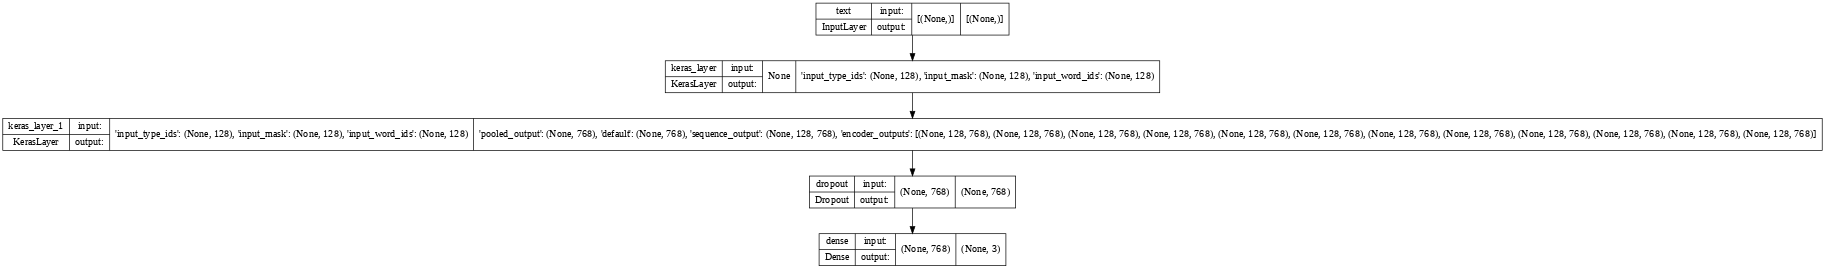

In [ ]:
model = Model(inputs=[text_input], outputs = [x_output])
plot_model(model, show_shapes=True, expand_nested=True, show_layer_names=True, dpi=50)

In [ ]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

# Model complite

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=(0.00001)), metrics=['accuracy'])

checkpointer = ModelCheckpoint(
  filepath = DIR + 'model_cls_best.h5', 
  monitor = 'val_accuracy',
  mode = 'max',
  verbose = 1, 
  save_best_only = True
)

In [ ]:
history = model.fit(
  x_train,
  y_train, 
  epochs = 20,
  batch_size = 16,
  validation_data = (x_val, y_val),
  callbacks = [checkpointer],
  verbose = 1
)

Epoch 1/20
110/110 [==============================] - ETA: 0s - loss: 0.6472 - accuracy: 0.3515
Epoch 1: val_accuracy improved from -inf to 0.65675, saving model to /content/drive/MyDrive/Colab Notebooks/DAN/feedback_tracking/files/model_cls_best.h5
110/110 [==============================] - 94s 735ms/step - loss: 0.6472 - accuracy: 0.3515 - val_loss: 0.5733 - val_accuracy: 0.6568
Epoch 2/20
110/110 [==============================] - ETA: 0s - loss: 0.4440 - accuracy: 0.7023
Epoch 2: val_accuracy improved from 0.65675 to 0.84897, saving model to /content/drive/MyDrive/Colab Notebooks/DAN/feedback_tracking/files/model_cls_best.h5
110/110 [==============================] - 65s 591ms/step - loss: 0.4440 - accuracy: 0.7023 - val_loss: 0.2525 - val_accuracy: 0.8490
Epoch 3/20
110/110 [==============================] - ETA: 0s - loss: 0.2250 - accuracy: 0.8821
Epoch 3: val_accuracy improved from 0.84897 to 0.92220, saving model to /content/drive/MyDrive/Colab Notebooks/DAN/feedback_tracking/

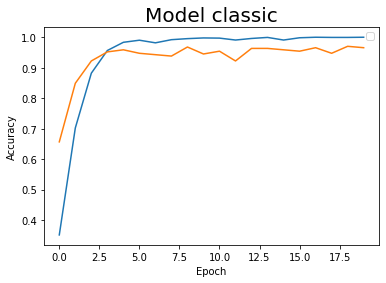

In [ ]:
# Оображаем график точности обучения
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(label='Model classic', fontsize=20)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
model.load_weights(DIR + 'model_cls_best.h5')

# Evaluate the model

In [ ]:
loss, accuracy = model.evaluate(x_train, y_train)

print('Train:')
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

val_loss, val_accuracy = model.evaluate(x_val, y_val)
print()
print('Val:')
print(f'Val loss: {val_loss}')
print(f'Val accuracy: {val_accuracy}')

55/55 [==============================] - 18s 321ms/step - loss: 5.5197e-04 - accuracy: 1.0000
Train:
Loss: 0.0005519744008779526
Accuracy: 1.0
14/14 [==============================] - 4s 317ms/step - loss: 0.1118 - accuracy: 0.9703

Val:
Val loss: 0.11177989095449448
Val accuracy: 0.970251739025116


# ======= My approach to problem solving =======
The essence of the approach is to use BERT fine-tuning, but at the same time provide additional features to the input:

*   comment length / max comment length
*   for text uniqueness (in review)
*   mean word length

Let's create a neural network with several inputs, separately for the BERT layer ['pooled_output'] and separately for the feature layer

# Feature Extraction

In [ ]:
max_len = data['text'].map(len).max()
max_len

3771

In [ ]:
def get_features(df):
  features_list = []
  for i in range(df.shape[0]):
    words = df.iloc[i].split()
    count = len(words)
    if count > 0:
      mean = round(100*sum(map(len, words))/count)
      uniq = round(100*len(set(words))/count)
    else:
      mean = 0
      uniq = 0

    features_list.append([count, mean, uniq])

  return np.array(features_list)

In [ ]:
x_features = get_features(data['text'])

In [ ]:
x_train_features, x_val_features, y_train_features, y_val_features = train_test_split(x_features, y, train_size=0.8, random_state=RANDOM_STATE)

# Model with multiple inputs

In [ ]:
text_input = Input(shape=(), dtype=tf.string, name='text_input')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

features_input = Input(shape=(3), name='features_input')

x_1 = outputs['pooled_output']
x = concatenate([x_1, features_input])
x = Dropout(0.25)(x)
x_output = Dense(3, activation='softmax')(x)

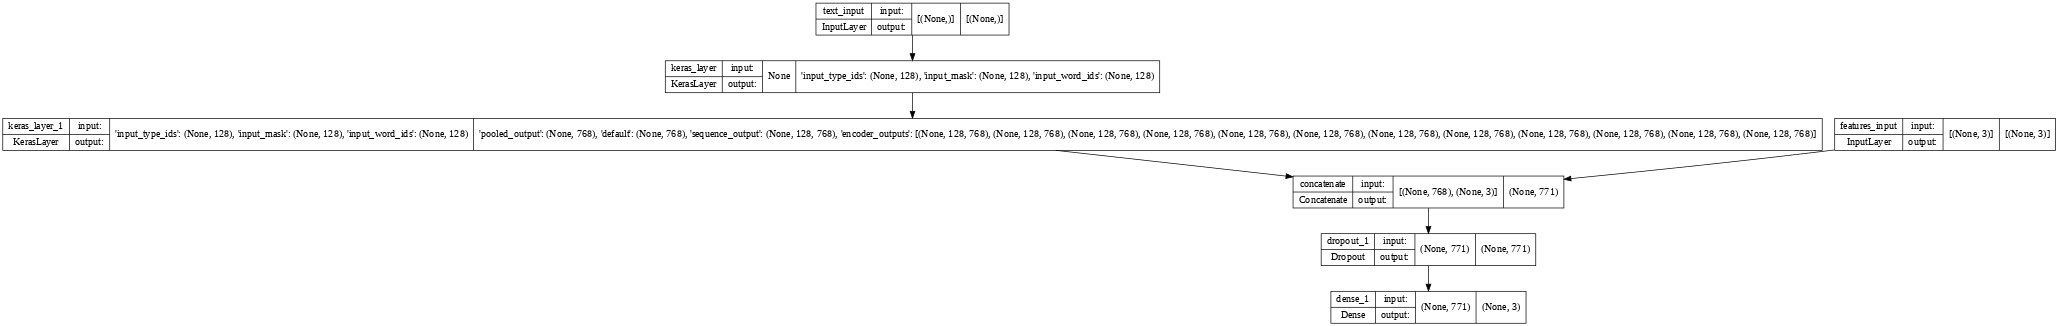

In [ ]:
model_m = Model(inputs=[text_input, features_input], outputs = [x_output])
plot_model(model_m, show_shapes=True, expand_nested=True, show_layer_names=True, dpi=50)

In [ ]:
print(model_m.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text_input[0][0]']             
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                

# Model complite

In [ ]:
model_m.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=(0.00001)), metrics=['accuracy'])

checkpointer = ModelCheckpoint(
  filepath = DIR + 'model_m_cls_best.h5', 
  monitor = 'val_accuracy',
  mode = 'max',
  verbose = 1, 
  save_best_only = True
)

In [ ]:
history = model_m.fit(
  [x_train, x_train_features],
  y_train, 
  epochs = 20,
  batch_size = 16,
  validation_data = ([x_val, x_val_features], y_val),
  callbacks = [checkpointer],
  verbose = 1
)

Epoch 1/20
110/110 [==============================] - ETA: 0s - loss: 8.8414 - accuracy: 0.4803
Epoch 1: val_accuracy improved from -inf to 0.65675, saving model to /content/drive/MyDrive/Colab Notebooks/DAN/feedback_tracking/files/model_m_cls_best.h5
110/110 [==============================] - 98s 843ms/step - loss: 8.8414 - accuracy: 0.4803 - val_loss: 3.6304 - val_accuracy: 0.6568
Epoch 2/20
110/110 [==============================] - ETA: 0s - loss: 3.3217 - accuracy: 0.7310
Epoch 2: val_accuracy improved from 0.65675 to 0.78490, saving model to /content/drive/MyDrive/Colab Notebooks/DAN/feedback_tracking/files/model_m_cls_best.h5
110/110 [==============================] - 65s 588ms/step - loss: 3.3217 - accuracy: 0.7310 - val_loss: 1.0887 - val_accuracy: 0.7849
Epoch 3/20
110/110 [==============================] - ETA: 0s - loss: 1.6671 - accuracy: 0.8065
Epoch 3: val_accuracy improved from 0.78490 to 0.91991, saving model to /content/drive/MyDrive/Colab Notebooks/DAN/feedback_track

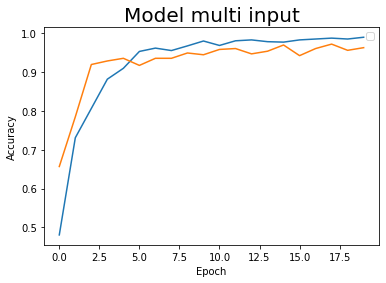

In [ ]:
# Оображаем график точности обучения
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(label='Model multi input', fontsize=20)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate the model

In [ ]:
model_m.load_weights(DIR + 'model_m_cls_best.h5')

In [ ]:
loss, accuracy = model_m.evaluate([x_train, x_train_features], y_train)

print('Train:')
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

val_loss, val_accuracy = model_m.evaluate([x_val, x_val_features], y_val)
print()
print('Val:')
print(f'Val loss: {val_loss}')
print(f'Val accuracy: {val_accuracy}')

55/55 [==============================] - 21s 384ms/step - loss: 0.0118 - accuracy: 0.9966
Train:
Loss: 0.011768954806029797
Accuracy: 0.9965655207633972
14/14 [==============================] - 4s 316ms/step - loss: 0.2909 - accuracy: 0.9725

Val:
Val loss: 0.2908712327480316
Val accuracy: 0.972540020942688


# Save model

In [ ]:
model.save(DIR+'model_m_cls.h5')

# Report

Classical approach to sentiment analysis classification on BERT model with fine tuning from tensorflow:
https://www.tensorflow.org/tutorials/keras/classification:

* accuracy: **0.9994**, 
* val_accuracy: **0.9703**, 

my model:

* accuracy: **0.9966**, 
* val_accuracy: **0.9725**